# Synthetic data generation

In [16]:
# Connecting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!pip install polygenerator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import os
import numpy as np
import shutil
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from polygenerator import (
    random_polygon,
    random_star_shaped_polygon,
    random_convex_polygon,
)
import random

In [ ]:
!wget https://data.vision.ee.ethz.ch/csergi/share/davis/DAVIS-2017-trainval-Full-Resolution.zip
!wget https://data.vision.ee.ethz.ch/csergi/share/davis/DAVIS-2019-Unsupervised-test-dev-480p.zip

!unzip -d DAVIS-2017-trainval-Full-Resolution /content/DAVIS-2017-trainval-Full-Resolution.zip 
!unzip -d DAVIS-2019-Unsupervised-test-dev-480p /content/DAVIS-2019-Unsupervised-test-dev-480p.zip 

In [64]:
!rm -r background_images
!rm -r foreground_images
os.mkdir('background_images') 
os.mkdir('foreground_images')

# BACKGROUND (choosing some pictures from DAVIS datatset)
background_files = [
'/content/DAVIS-2019-Unsupervised-test-dev-480p/DAVIS/JPEGImages/480p/butterfly/00079.jpg',
'/content/DAVIS-2019-Unsupervised-test-dev-480p/DAVIS/JPEGImages/480p/ducks/00000.jpg',
'/content/DAVIS-2019-Unsupervised-test-dev-480p/DAVIS/JPEGImages/480p/giraffes/00008.jpg',
'/content/DAVIS-2019-Unsupervised-test-dev-480p/DAVIS/JPEGImages/480p/snowboard-race/00000.jpg',
'/content/DAVIS-2019-Unsupervised-test-dev-480p/DAVIS/JPEGImages/480p/swimmer/00018.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/bear/00000.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/blackswan/00000.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/bmx-bumps/00005.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/boat/00000.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/camel/00000.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/cows/00000.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/soccerball/00000.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/sheep/00000.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/motocross-bumps/00000.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/mallard-fly/00000.jpg',
'/content/DAVIS-2017-trainval-Full-Resolution/DAVIS/JPEGImages/Full-Resolution/hike/00000.jpg']

for x in range(len(background_files)):
  img = cv2.imread(background_files[x])
  res = cv2.resize(img, dsize=(240, 160))
  cv2.imwrite('/content/background_images/background_'+str(x)+'.png', res)


# FOREGROUND
foreground_files = [
'/content/drive/MyDrive/foregrounds/5192807-texture-of-a-wall-of-orange-colour-for-a-background.webp',
'/content/drive/MyDrive/foregrounds/pexels-fwstudio-132204.jpeg',
'/content/drive/MyDrive/foregrounds/pexels-photo-2832432.webp',
'/content/drive/MyDrive/foregrounds/photo-1581299327801-faeb40ea459e.jpeg',
'/content/drive/MyDrive/foregrounds/photo-1650295031169-cb1207632f7c.jpeg',
'/content/drive/MyDrive/foregrounds/texture-1909992__340.jpeg'
]

for x in range(len(foreground_files)):
  img = cv2.imread(foreground_files[x])
  res = cv2.resize(img, dsize=(240, 160))
  cv2.imwrite('/content/foreground_images/foreground_'+str(x)+'.png', res)

background_path = '/content/background_images/'
foreground_path = '/content/foreground_images/'

background_filenames = [f for f in os.listdir(background_path) if f.endswith('.png')]
foreground_filenames = [f for f in os.listdir(foreground_path) if f.endswith('.png')]

In [58]:
# Creating a foreground blob
def foreground_blob(image_path, points=3):
  # Load the image with 3 channels (BGR)
  image = cv2.imread(image_path)
  H = image.shape[0]
  W = image.shape[1]
  
  # Crating mask
  mask = 255*np.ones((H, W), dtype=np.uint8)
  polygon = random_polygon(num_points=points)
  points = np.array([(x*H//3, y*W//3) for x, y in polygon])
  

  # Points to be cropped
  points = np.array([[(x, y) for x, y in points]], dtype=np.int32)
  cv2.fillPoly(mask, points, 0)
  alpha_channel = -mask+255

  # Add the alpha channel to the image
  img = cv2.merge((image, alpha_channel))

  # Find the non-zero (i.e., non-transparent) pixels in the alpha channel
  _, alpha = cv2.threshold(img[:, :, 3], 0, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(alpha, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Get the bounding box of the non-zero pixels
  x, y, w, h = cv2.boundingRect(contours[0])

  # Crop the image using the bounding box and transform
  cropped_img = img[y:y+h, x:x+w, :]
  return cropped_img

In [59]:
def merge_images(background, blobs):
  background_img = background.copy()
  # Get the dimensions of the background image
  bg_h, bg_w, _ = background_img.shape

  for blob in blobs:
    # If blob is not in scene continue
    if blob.in_scene() == False:
      continue

    # Get the location of blob
    x, y = blob.position
    blob = blob.image.copy()

    # Replace pixels in background by blob, deal with out of frame blobs
    if x < 0:
       blob_h = blob.shape[0] + x
       blob = blob[-x:, :, :]
       x = 0
    else:
      blob_h = blob.shape[0]
    
    if y < 0:
      blob_w = blob.shape[1] + y
      blob = blob[:, -y:, :]
      y = 0
    else:
      blob_w = blob.shape[1]

    if x + blob.shape[0] > bg_h:
      blob_h = bg_h - x
      blob = blob[:blob_h, :, :]

    if y + blob.shape[1] > bg_w:
      blob_w = bg_w - y
      blob = blob[:, :blob_w, :]
    
    background_img[x:x+blob_h, y:y+blob_w] = np.where(blob[...,3][:,:,None]>0, blob[...,:3], background_img[x:x+blob_h, y:y+blob_w])

  return background_img

In [60]:
class Blob():
  def __init__(self, image_path, points=3):
    self.image = foreground_blob(image_path, points=points)

    # pick random position
    blob_h, blob_w, _ = self.image.shape
    y = np.random.randint(0, 240 - blob_w//2 + 1)
    x = np.random.randint(0, 160 - blob_h//2 + 1)
    self.position = (x, y)

    # pick random velocity, make the blob move across the frame so less empty frames are generated
    
    if self.position[0] < 80:
      v_x = random.randint(0, 15)
    else:
      v_x = random.randint(-15, 0)

    if self.position[1] < 120:
      v_y = random.randint(0, 20)
    else:
      v_y = random.randint(-20, 0)


    self.velocity = (v_x, v_y)  

  def change_position(self, new_position):
    self.position = new_position

  def in_scene(self):
    # see if blob is in scene
    in_scene = (-self.image.shape[0]<self.position[0]<160) and (-self.image.shape[1]<self.position[1]<240)
    return in_scene

class Video_Objects:
  def __init__(self, num_blobs):

    # Create background from randomly sampled from backgrounds files
    random_background_filename = random.choice(background_filenames)
    self.background = cv2.imread(background_path+random_background_filename)
    
    # Create blobs, randomly sample foregrounds and number of edge for polygon (3,8)
    blobs = list()
    random_blob_filenames = np.random.choice(foreground_filenames, size=num_blobs, replace=False)
    for filename in random_blob_filenames:
      blob = Blob(foreground_path+filename, points=random.randrange(3,4))
      blobs.append(blob)
    self.blobs = blobs

In [61]:
class Scene:
  def __init__(self, video_objects):
    self.background = video_objects.background
    self.blobs = video_objects.blobs
  
  def create_frame(self):
    merged = merge_images(self.background, self.blobs)
    return merged

  def move_blobs(self):
    for blob in self.blobs:
      x, y = blob.position
      velocity = blob.velocity      
      new_x = x+velocity[0]
      new_y = y+velocity[1]
      blob.change_position((new_x, new_y))

  def blobs_in_scene(self):
    visibility = []
    for blob in self.blobs:
      visibility.append(blob.in_scene())
    return np.any(np.array(visibility))


In [62]:
def save_frame(image, video_num, frame_num):
  filename = "/content/frames/video{:04d}/frame_{:03d}.jpg".format(video_num, frame_num)
  cv2.imwrite(filename, image)

## Testing

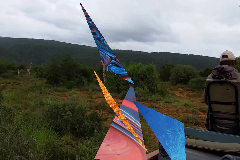

frame 1


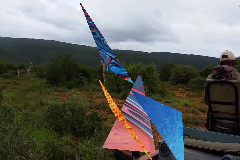

frame 2


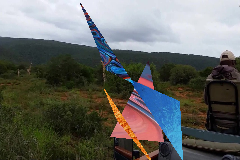

frame 3


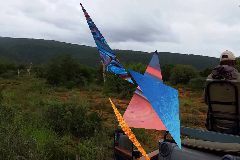

frame 4


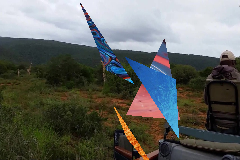

frame 5


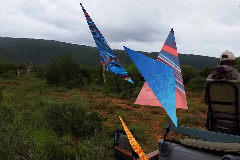

frame 6


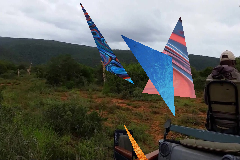

frame 7


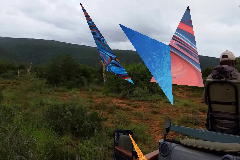

frame 8


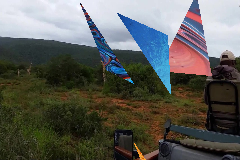

frame 9


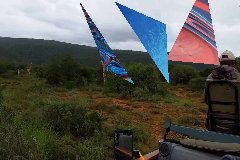

frame 10


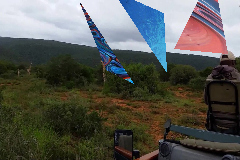

frame 11


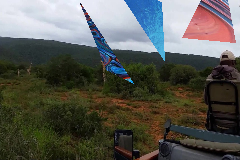

frame 12


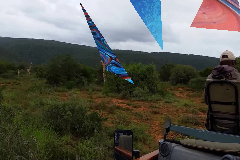

frame 13


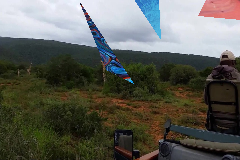

frame 14


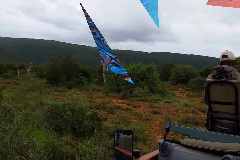

frame 15


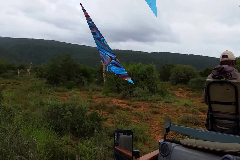

frame 16


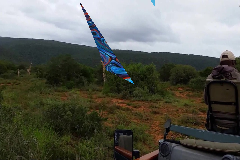

frame 17


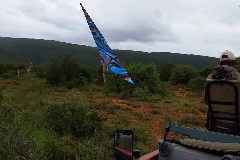

frame 18


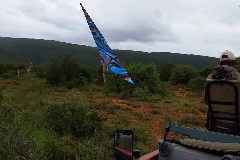

frame 19


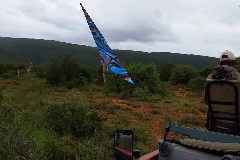

frame 20


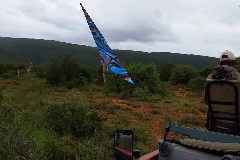

frame 21


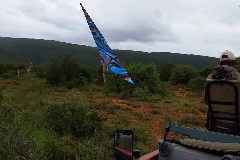

frame 22


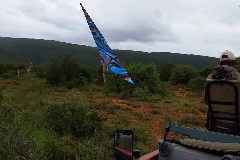

frame 23


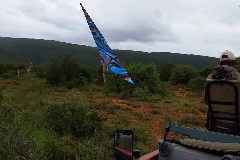

frame 24


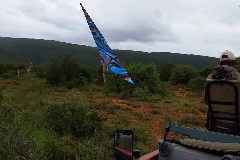

frame 25


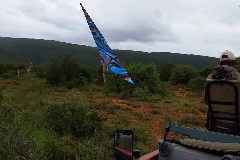

frame 26


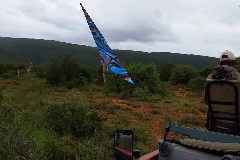

frame 27


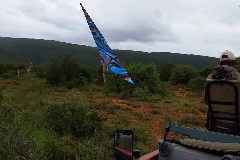

frame 28


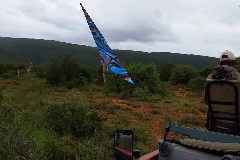

frame 29


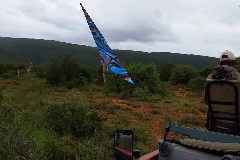

frame 30


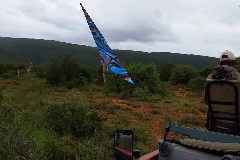

frame 31


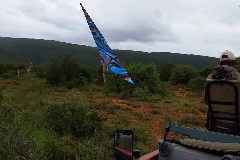

frame 32


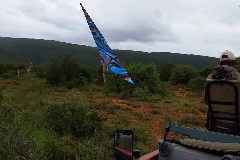

frame 33


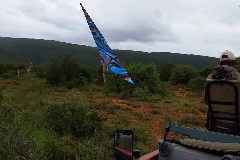

frame 34


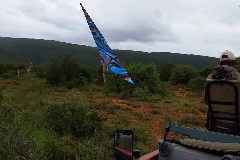

frame 35


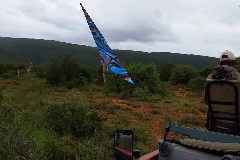

frame 36


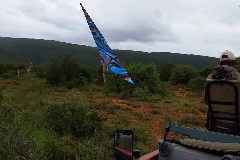

frame 37


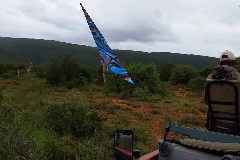

frame 38


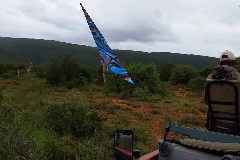

frame 39


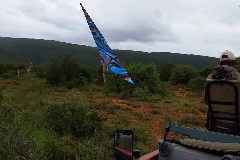

frame 40


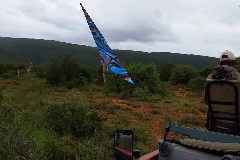

frame 41


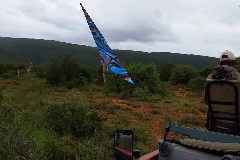

frame 42


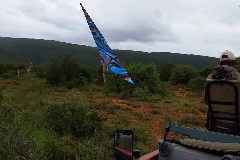

frame 43


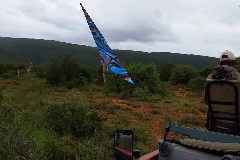

frame 44


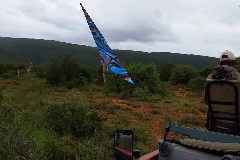

frame 45


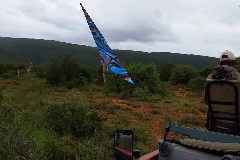

frame 46


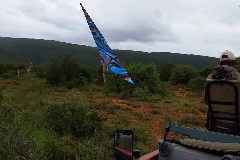

frame 47


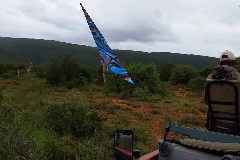

frame 48


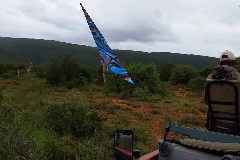

frame 49


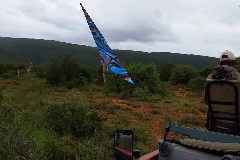

frame 50


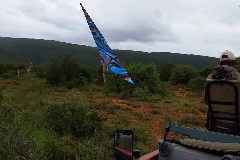

frame 51


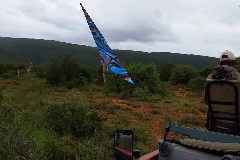

frame 52


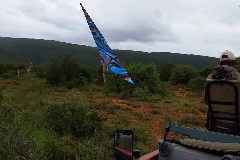

frame 53


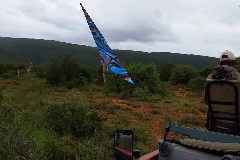

frame 54


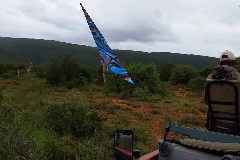

frame 55


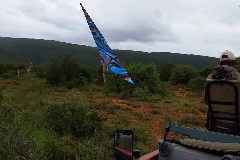

frame 56


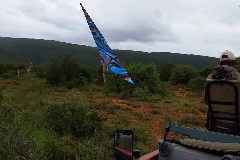

frame 57


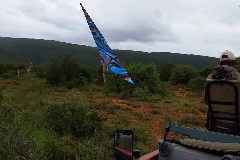

frame 58


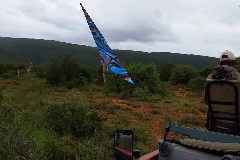

frame 59


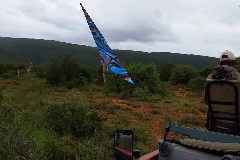

frame 60


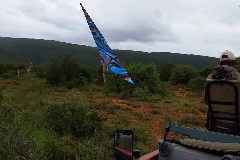

frame 61


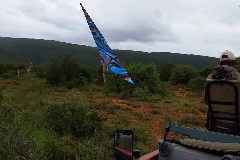

frame 62


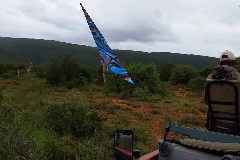

frame 63


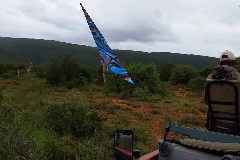

frame 64


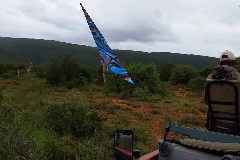

frame 65


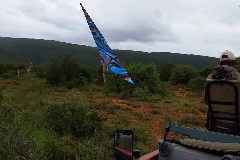

frame 66


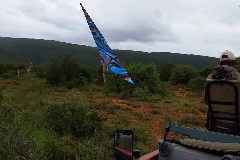

frame 67


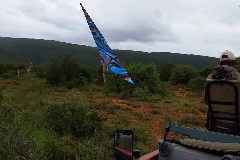

frame 68


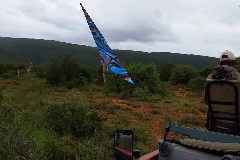

frame 69


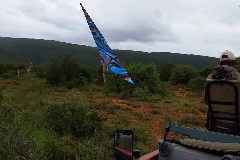

frame 70


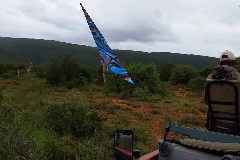

frame 71


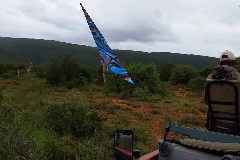

frame 72


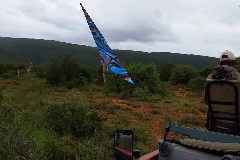

frame 73


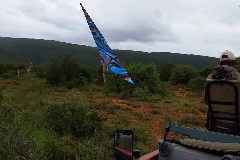

frame 74


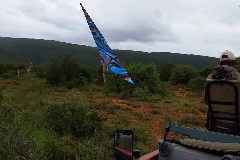

frame 75


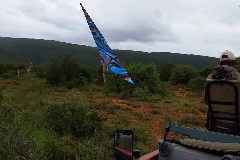

frame 76


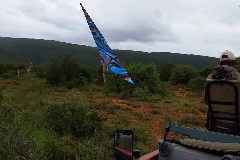

frame 77


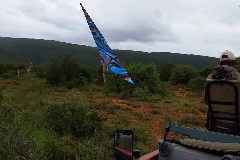

frame 78


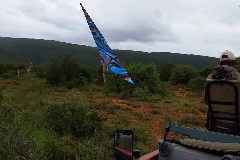

frame 79


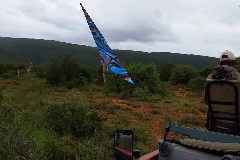

frame 80


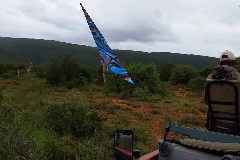

frame 81


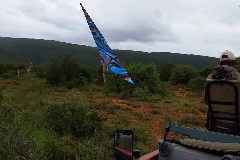

frame 82


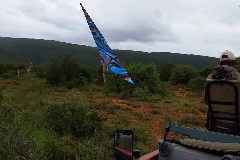

frame 83


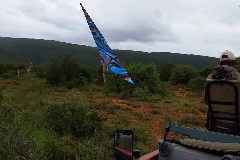

frame 84


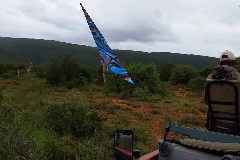

frame 85


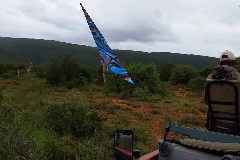

frame 86


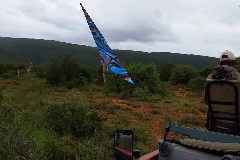

frame 87


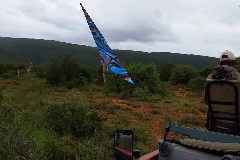

frame 88


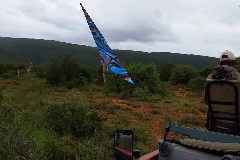

frame 89


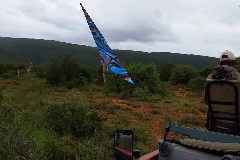

frame 90


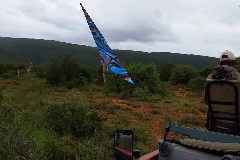

frame 91


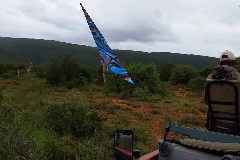

frame 92


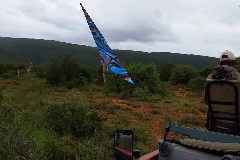

frame 93


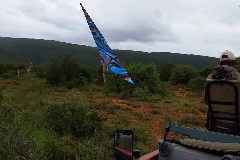

frame 94


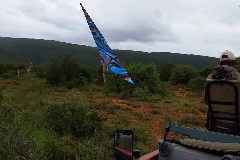

frame 95


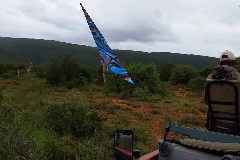

In [74]:
# Create Objects
v_objects = Video_Objects(random.randint(2,4))

# Create Scene with those objects
s = Scene(v_objects)
img = s.create_frame()
cv2_imshow(img)

# For each time step, move blobs
# If all blobs are out of the scene terminate
for x in range(1,96):
  s.move_blobs()
  print("frame", x)
  if not s.blobs_in_scene() and x>8 and x%8==0:
    break
  img = s.create_frame()
  cv2_imshow(img)


## Data Generation

In [ ]:
# create 80,000 frames -> 10,000 samples
# while frames_num < 80,000:
#   for each video: 
#     pick random background and random objects with random velocities and position
#     create scene and save the frame
#     for t in time step (max 96):
#      move objects
#      if objects are not in frame:
#         break
#      create scene and save

# Data structure:
# frames
#  |-- video1
#  |        |-- frame1, ...  frame100
#  |
#  |-- video2

In [55]:
!rm -r /content/frames/
os.mkdir('frames')

frames = 0
video = 0

# Generate video frames until we have 80_000 of them
while frames < 80_000:

  # Create Objects (2-4 blobs)
  v_objects = Video_Objects(random.randint(2,4))

  # Create directory for a new video
  os.mkdir("/content/frames/video{:04d}".format(video))

  # Create Scene with those objects and save first frame
  s = Scene(v_objects)
  frame = s.create_frame()
  save_frame(frame, video, 0)

  # In each time step (maximum video length is 96 frames, minimum is 8 frames)
  for x in range(1,97):

    # Move blobs in the scene
    s.move_blobs() 

    # If all blobs are out of the scene terminate
    if not s.blobs_in_scene() and x>8 and x%8==0:
      break

    # Create a frame with moved objects and save
    frame = s.create_frame() 
    save_frame(frame, video, x)
    # Increment frame count
    frames+=1 

  print("Generated video {} with {} frames". format(video, x))
  # Increment video count
  video += 1
  

Generated vide 0 with 16 frames
Generated vide 1 with 24 frames
Generated vide 2 with 24 frames
Generated vide 3 with 16 frames
Generated vide 4 with 16 frames
Generated vide 5 with 24 frames
Generated vide 6 with 32 frames
Generated vide 7 with 24 frames
Generated vide 8 with 16 frames
Generated vide 9 with 72 frames
Generated vide 10 with 32 frames
Generated vide 11 with 24 frames
Generated vide 12 with 32 frames
Generated vide 13 with 56 frames
Generated vide 14 with 40 frames
Generated vide 15 with 48 frames
Generated vide 16 with 32 frames
Generated vide 17 with 16 frames
Generated vide 18 with 16 frames
Generated vide 19 with 16 frames
Generated vide 20 with 24 frames
Generated vide 21 with 16 frames
Generated vide 22 with 24 frames
Generated vide 23 with 16 frames
Generated vide 24 with 16 frames
Generated vide 25 with 88 frames
Generated vide 26 with 40 frames
Generated vide 27 with 24 frames
Generated vide 28 with 32 frames
Generated vide 29 with 24 frames
Generated vide 30 wi

In [56]:
from datetime import date
TODAY = date.today()

# ZIP AND SAVE DATASET
data_path ='/content/frames/'
!cd "$data_path" && zip -r /content/synthetic_data_"$TODAY".zip .
!cp /content/synthetic_data_"$TODAY".zip /content/drive/MyDrive/

Streaming output truncated to the last 5000 lines.
  adding: video1661/frame_002.jpg (deflated 1%)
  adding: video1661/frame_034.jpg (deflated 1%)
  adding: video1661/frame_010.jpg (deflated 1%)
  adding: video2000/ (stored 0%)
  adding: video2000/frame_070.jpg (deflated 1%)
  adding: video2000/frame_042.jpg (deflated 1%)
  adding: video2000/frame_023.jpg (deflated 1%)
  adding: video2000/frame_064.jpg (deflated 1%)
  adding: video2000/frame_004.jpg (deflated 1%)
  adding: video2000/frame_096.jpg (deflated 1%)
  adding: video2000/frame_076.jpg (deflated 1%)
  adding: video2000/frame_066.jpg (deflated 1%)
  adding: video2000/frame_061.jpg (deflated 1%)
  adding: video2000/frame_090.jpg (deflated 1%)
  adding: video2000/frame_051.jpg (deflated 1%)
  adding: video2000/frame_058.jpg (deflated 1%)
  adding: video2000/frame_032.jpg (deflated 1%)
  adding: video2000/frame_078.jpg (deflated 1%)
  adding: video2000/frame_037.jpg (deflated 1%)
  adding: video2000/frame_033.jpg (deflated 1%)
  ad